In [1]:
import pandas as pd
from datetime import datetime
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

In [2]:
DATA_FILE_PATH = './Online Retail.xlsx'
df = pd.read_excel(DATA_FILE_PATH, engine='openpyxl')

In [3]:
print('shape: ', df.shape)
print(df.head())  

shape:  (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
for column in df.columns:
    print(f'Number of NANs in column {column}: ', df[column].isna().sum())

Number of NANs in column InvoiceNo:  0
Number of NANs in column StockCode:  0
Number of NANs in column Description:  1454
Number of NANs in column Quantity:  0
Number of NANs in column InvoiceDate:  0
Number of NANs in column UnitPrice:  0
Number of NANs in column CustomerID:  135080
Number of NANs in column Country:  0


In [5]:
df = df.dropna()
df.shape

(406829, 8)

Calculate time stamp to investigate how recent the purchase is.

In [6]:
df['timestamp'] = [datetime.timestamp(x) for x in df['InvoiceDate']]
print("timestamp =", df['timestamp'].head())

timestamp = 0    1.291188e+09
1    1.291188e+09
2    1.291188e+09
3    1.291188e+09
4    1.291188e+09
Name: timestamp, dtype: float64


In [7]:
df['TotalSpendingPerItemType'] = df['UnitPrice'] * df['Quantity']
print("Total Spending = ", df['TotalSpendingPerItemType'].head())
df['TotalSpending'] = df.groupby('CustomerID')['TotalSpendingPerItemType'].transform('sum')
print("Total Spending = ", df['TotalSpending'].head())
df['InvoicePrice'] = df.groupby('InvoiceNo')['TotalSpendingPerItemType'].transform('sum')
print("Invoice Price = ", df['InvoicePrice'].head())
df['NumberOfTransactions'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')
print("Number Of Transactions = ", df['NumberOfTransactions'].head())
df['AveragePurchaseValue'] = df['TotalSpending'] / df['NumberOfTransactions']
print("Average of Purchase = ", df['AveragePurchaseValue'].head())
df['TotalQuantityPurchased'] = df.groupby('CustomerID')['Quantity'].transform('sum')
print("Total Quantity Purchased = ", df['TotalQuantityPurchased'].head())
df['MaxInterval'] = df.groupby('CustomerID')['timestamp'].transform('max') - df.groupby('CustomerID')['timestamp'].transform('min')
print("Max Interval between Purchases = ", df['MaxInterval'].head())
df['FrequencyInverse'] = df['MaxInterval'] / df['NumberOfTransactions']
print("Frequency Inverse = ", df['FrequencyInverse'].head())
df['MostRecent'] = df['timestamp'].max()
print("Most Recent Purchase = ", df['MostRecent'].head())

Total Spending =  0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: TotalSpendingPerItemType, dtype: float64
Total Spending =  0    5288.63
1    5288.63
2    5288.63
3    5288.63
4    5288.63
Name: TotalSpending, dtype: float64
Invoice Price =  0    139.12
1    139.12
2    139.12
3    139.12
4    139.12
Name: InvoicePrice, dtype: float64
Number Of Transactions =  0    35
1    35
2    35
3    35
4    35
Name: NumberOfTransactions, dtype: int64
Average of Purchase =  0    151.103714
1    151.103714
2    151.103714
3    151.103714
4    151.103714
Name: AveragePurchaseValue, dtype: float64
Total Quantity Purchased =  0    1693
1    1693
2    1693
3    1693
4    1693
Name: TotalQuantityPurchased, dtype: int64
Max Interval between Purchases =  0    6156720.0
1    6156720.0
2    6156720.0
3    6156720.0
4    6156720.0
Name: MaxInterval, dtype: float64
Frequency Inverse =  0    175906.285714
1    175906.285714
2    175906.285714
3    175906.285714
4    175906.285714
Name: FrequencyI

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,timestamp,TotalSpendingPerItemType,TotalSpending,InvoicePrice,NumberOfTransactions,AveragePurchaseValue,TotalQuantityPurchased,MaxInterval,FrequencyInverse,MostRecent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1.291188e+09,15.30,5288.63,139.12,35,151.103714,1693,6156720.0,175906.285714,1.323431e+09
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1.291188e+09,20.34,5288.63,139.12,35,151.103714,1693,6156720.0,175906.285714,1.323431e+09
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1.291188e+09,22.00,5288.63,139.12,35,151.103714,1693,6156720.0,175906.285714,1.323431e+09
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1.291188e+09,20.34,5288.63,139.12,35,151.103714,1693,6156720.0,175906.285714,1.323431e+09
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1.291188e+09,20.34,5288.63,139.12,35,151.103714,1693,6156720.0,175906.285714,1.323431e+09


In [9]:
columns_to_drop = ['MaxInterval', 'InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'timestamp', 'TotalSpendingPerItemType', 'InvoicePrice', 'UnitPrice', 'Quantity']
features = df.groupby('CustomerID').first()
features = features.drop(columns = columns_to_drop)
print(features.shape)
features.head()


(4372, 7)


,Country,TotalSpending,NumberOfTransactions,AveragePurchaseValue,TotalQuantityPurchased,FrequencyInverse,MostRecent
CustomerID,,,,,,,
12346.0,United Kingdom,0.00,2,0.000000,0,4.800000e+02,1.323431e+09
12347.0,Iceland,4310.00,7,615.714286,2458,4.505614e+06,1.323431e+09
12348.0,Finland,1797.24,4,449.310000,2341,6.106560e+06,1.323431e+09
12349.0,Italy,1757.55,1,1757.550000,631,0.000000e+00,1.323431e+09
12350.0,Norway,334.40,1,334.400000,197,0.000000e+00,1.323431e+09


In [10]:
numeric_columns = ['TotalSpending', 'NumberOfTransactions', 'AveragePurchaseValue', 'TotalQuantityPurchased', 'FrequencyInverse', 'MostRecent']
for column in numeric_columns:
    Q1 = features[column].quantile(0.25)
    Q3 = features[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    upper_array = np.where(features[column] >= upper)[0]
    lower_array = np.where(features[column] <= lower)[0]
    upper_array = [idx for idx in upper_array if idx in features.index]
    lower_array = [idx for idx in lower_array if idx in features.index]
    features = features[(features[column] >= lower) & (features[column] <= upper)]
    print(features.shape)

(3949, 7)
(3662, 7)
(3466, 7)
(3217, 7)
(3129, 7)
(3129, 7)


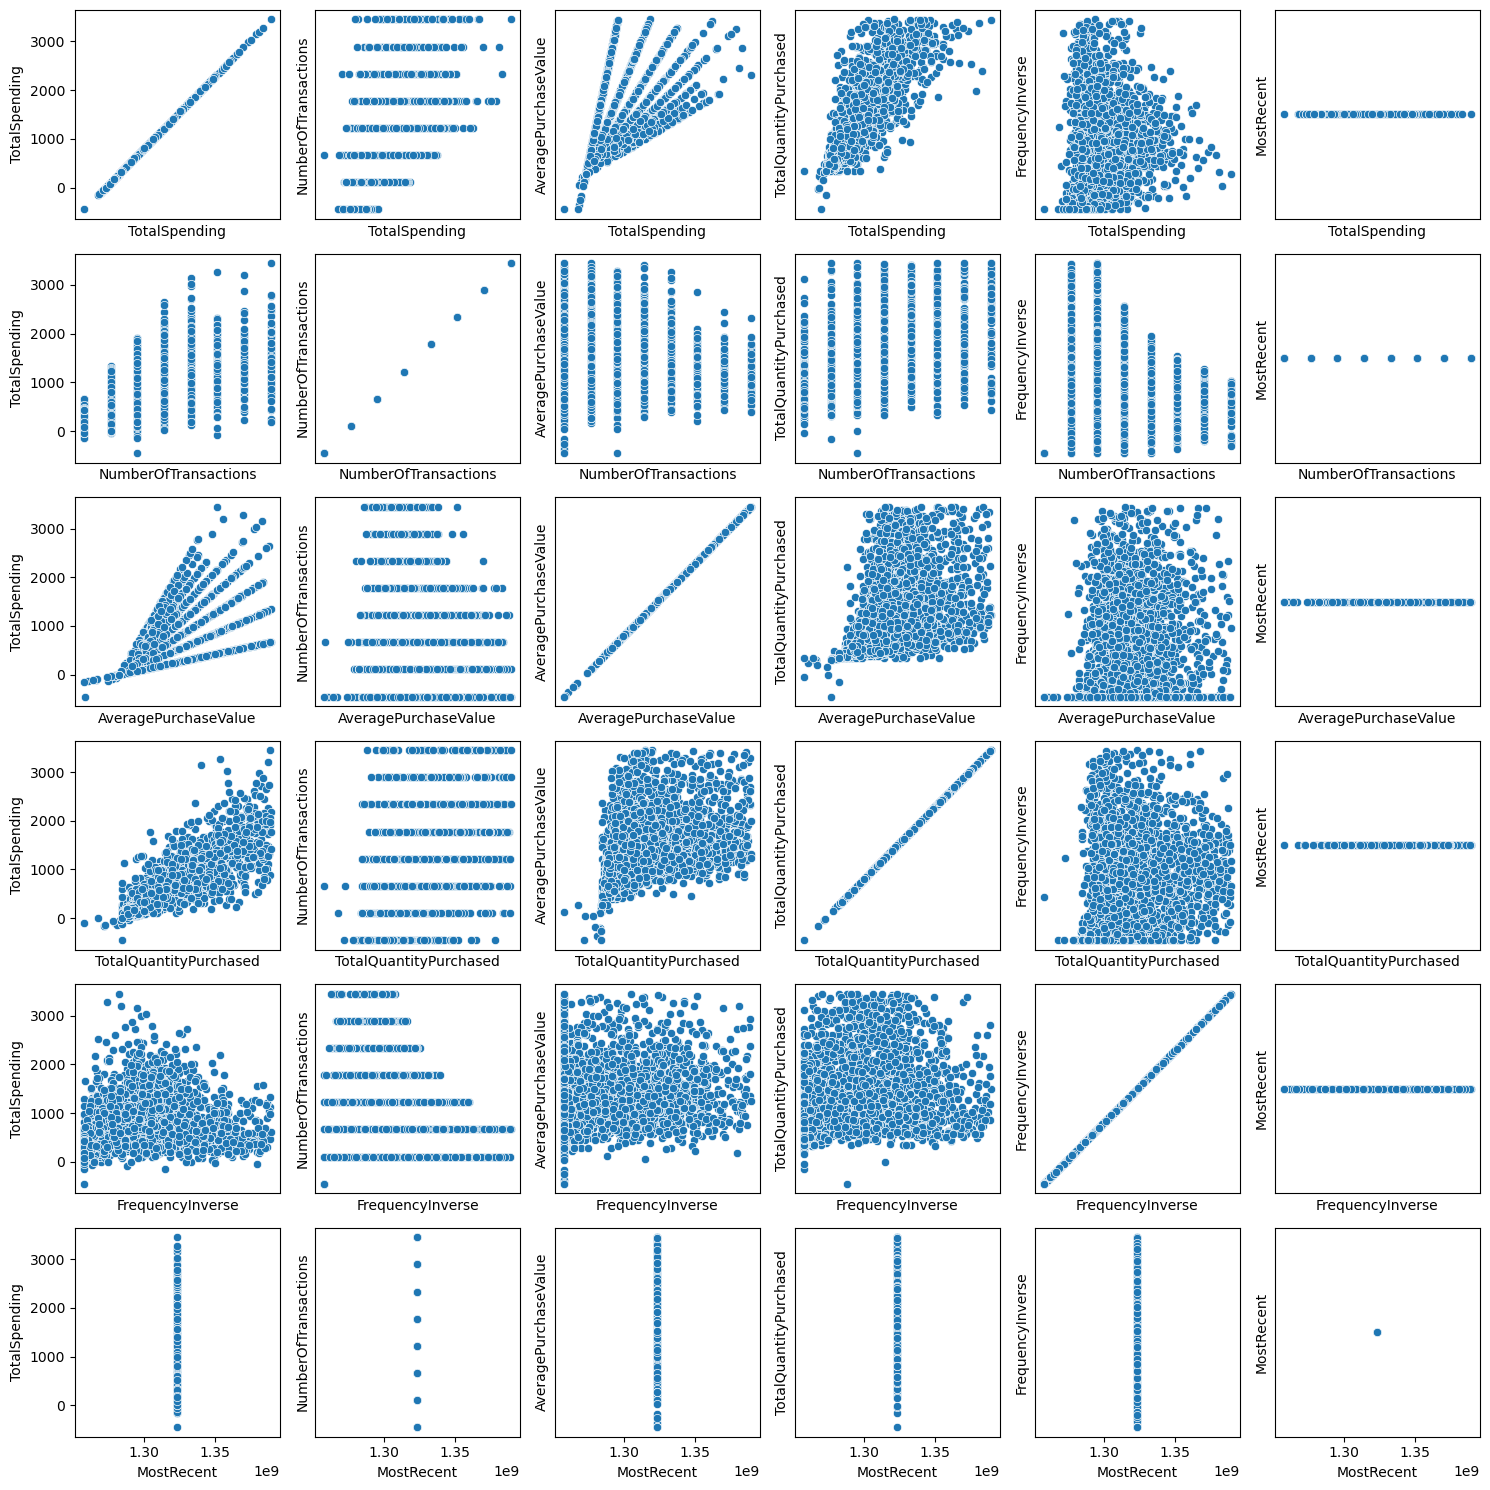

In [13]:
numeric_columns = ['TotalSpending', 'NumberOfTransactions', 'AveragePurchaseValue', 'TotalQuantityPurchased', 'FrequencyInverse', 'MostRecent']
num_cols = len(numeric_columns)
fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(15, 15))

# Iterate over the DataFrame columns to plot each pair
for i, x_col in enumerate(numeric_columns):
    for j, y_col in enumerate(numeric_columns):
        ax = axes[i, j]
        sns.scatterplot(data=features, x=x_col, y=y_col, ax=ax)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        if i != num_cols - 1:
            ax.set_xticks([])
        if j != 0:
            ax.set_yticks([])

plt.tight_layout()
plt.show()

In [12]:
std_scaler = StandardScaler()
 
features_scaled = std_scaler.fit_transform(features.drop(columns=['Country']).to_numpy())
features_scaled = pd.DataFrame(features_scaled, columns=['TotalSpending', 'NumberOfTransactions', 
                                                         'AveragePurchaseValue', 'TotalQuantityPurchased', 
                                                         'FrequencyInverse', 'MostRecent'])
 
print("Scaled Dataset Using StandardScaler")
features_scaled.head()


Scaled Dataset Using StandardScaler


,TotalSpending,NumberOfTransactions,AveragePurchaseValue,TotalQuantityPurchased,FrequencyInverse,MostRecent
0,-1.165716,-0.330176,-1.716457,-1.164860,-0.828704,0.0
1,-0.502985,-0.885020,0.715355,-0.474823,-0.828888,0.0
2,-0.989331,-0.885020,-1.069235,-1.094806,-0.828888,0.0
3,-0.255253,-0.885020,1.624376,-0.324206,-0.828888,0.0
4,1.149206,-0.330176,2.530706,-0.296184,1.633432,0.0


In [13]:
def one_hot_encode(df, column_name):
    if column_name in df.columns:

        df_encoded = pd.get_dummies(df[column_name], prefix=column_name, dtype=int)

        df.drop(column_name, axis=1, inplace=True)

        df = pd.concat([df, df_encoded], axis=1)

        print("One-hot encoding applied to column ", column_name, " successfully.")

        return df


features_reset_index = features.reset_index(drop=True)
print(features_reset_index.index)
print(features_scaled.index)

features_scaled['Country'] = features_reset_index['Country']
features_encoded = one_hot_encode(features_scaled, 'Country')
features_encoded.head()

RangeIndex(start=0, stop=3129, step=1)
RangeIndex(start=0, stop=3129, step=1)
One-hot encoding applied to column  Country  successfully.


,TotalSpending,NumberOfTransactions,AveragePurchaseValue,TotalQuantityPurchased,FrequencyInverse,MostRecent,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,...,Country_Poland,Country_Portugal,Country_Saudi Arabia,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,-1.165716,-0.330176,-1.716457,-1.164860,-0.828704,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.502985,-0.885020,0.715355,-0.474823,-0.828888,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.989331,-0.885020,-1.069235,-1.094806,-0.828888,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.255253,-0.885020,1.624376,-0.324206,-0.828888,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.149206,-0.330176,2.530706,-0.296184,1.633432,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
features_encoded = features_encoded.drop(columns=['Country_Unspecified'])

In [15]:
dim_red = PCA()
x_pca = dim_red.fit_transform(features_encoded)
print('dim red components: ', dim_red.components_)
print('Variance ratio: ', dim_red.explained_variance_ratio_)
print('Features Names: ', dim_red.get_feature_names_out())

dim red components:  [[ 5.59617043e-01  4.58124817e-01  2.60828710e-01 ... -5.84969125e-04
   1.05928078e-04 -4.62018718e-03]
 [ 1.30487511e-01 -4.48689039e-01  7.81320098e-01 ... -2.36408626e-04
   5.54468453e-04 -2.37577316e-02]
 [-1.63250323e-01 -3.93923155e-01  2.56977819e-01 ... -5.18151662e-04
  -3.40687001e-06  4.92498039e-04]
 ...
 [-2.19062592e-03  6.71195325e-04 -7.30389744e-05 ... -1.60832778e-03
   2.74603507e-01 -7.18507721e-04]
 [ 2.56611307e-04  1.08852799e-04 -7.51986442e-05 ... -1.84505071e-01
  -2.02792334e-01 -1.76316827e-01]
 [-0.00000000e+00  7.52782010e-18  9.39664630e-18 ... -2.77547310e-16
  -5.07833763e-16 -2.77841790e-16]]
Variance ratio:  [5.60120192e-01 2.32192955e-01 1.24459873e-01 3.98648469e-02
 1.58186574e-02 1.43987064e-02 3.44100975e-03 2.03496301e-03
 1.05068226e-03 7.60700391e-04 6.38171150e-04 5.37268149e-04
 4.95998395e-04 4.54858263e-04 3.91939754e-04 3.10255493e-04
 3.09961649e-04 3.09763580e-04 3.09552295e-04 3.09084542e-04
 2.63584066e-04 2.481

In [16]:
training_features = ['pca0' ,'pca1', 'pca2']
df_pca = pd.DataFrame(x_pca, columns=dim_red.get_feature_names_out())
print(df_pca.shape)

(3129, 35)


In [17]:
df_pca_working_set = df_pca[training_features]
df_pca_working_set = df_pca_working_set.reset_index(drop=True)
df_pca_working_set.head()

,pca0,pca1,pca2
0,-2.165061,-1.164111,-0.625901
1,-1.039673,1.181388,-0.009959
2,-2.109922,-0.353561,-0.282504
3,-0.583529,1.941820,0.158011
4,1.567345,1.617682,2.033837


<Axes: xlabel='pca0', ylabel='pca1'>

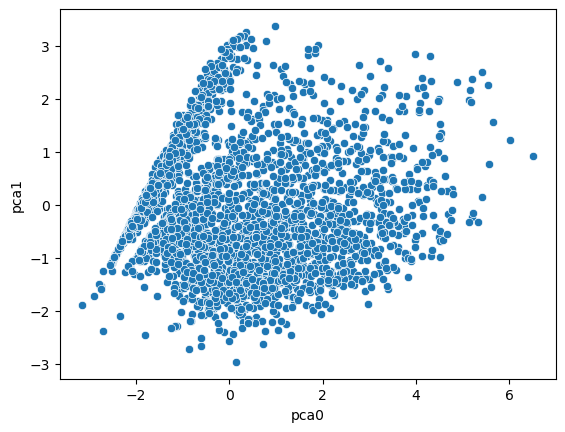

In [18]:
sns.scatterplot(data= df_pca_working_set ,x='pca0', y='pca1')

In [30]:

distortions = []
# inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 100)
 
for k in K:
    # Building and fitting the model
    whitened = whiten(df_pca_working_set.values)

    book = np.array((whitened[0],whitened[3000]))
    codebook, distortion = kmeans(whitened, 2)

    distortions.append(distortion)

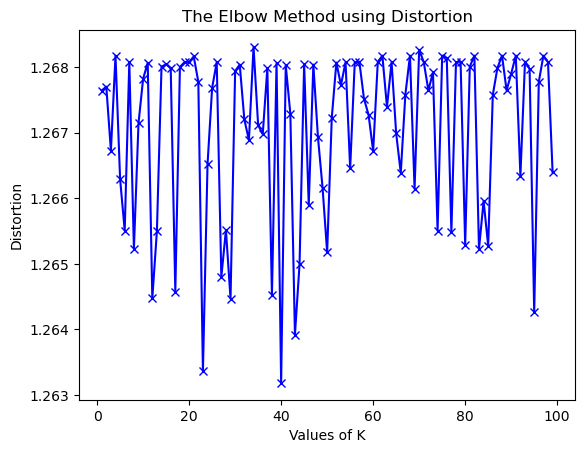

In [31]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Centroids:
 [[ 0.03619049  2.57191582  0.39553786]
 [ 0.58716599  0.74392443  0.8485049 ]
 [-0.63281816  0.9977013  -0.0290931 ]
 [ 0.63802901 -0.88235875  1.00220138]
 [-0.7678083   0.61859739 -0.14213623]
 [ 1.72789499  1.506064    1.22771039]
 [-0.24645089  1.89146849  0.20963742]
 [-1.02250095  0.08954003 -0.27207212]
 [-0.3764227  -1.1648      0.82224427]
 [ 0.85972701  1.96048366  0.05952311]
 [ 1.54378303 -1.09477413 -1.80821279]
 [ 0.97272592 -0.08932474  1.51095312]
 [-0.44178158 -0.67015165  0.08198628]
 [ 0.58595388 -0.24125577 -0.09832876]
 [-0.91635053  0.35434073 -0.19581471]
 [ 0.40193275 -1.71659503 -1.41802198]
 [ 1.81352288  0.10298318  0.08507378]
 [-1.14718158 -0.19207265 -0.33876496]
 [ 1.24385981  0.98292217 -0.59344364]
 [-0.17560632 -1.59101018  1.90310904]
 [ 0.77233063 -0.08759722 -1.21285094]
 [-0.65994247 -0.16168011 -0.56006289]
 [ 0.25666255 -1.22869064  3.01892705]
 [-0.85285434 -0.68092353 -0.62978665]
 [ 2.0231477  -0.03220101 -1.10613321]
 [-0.47878909

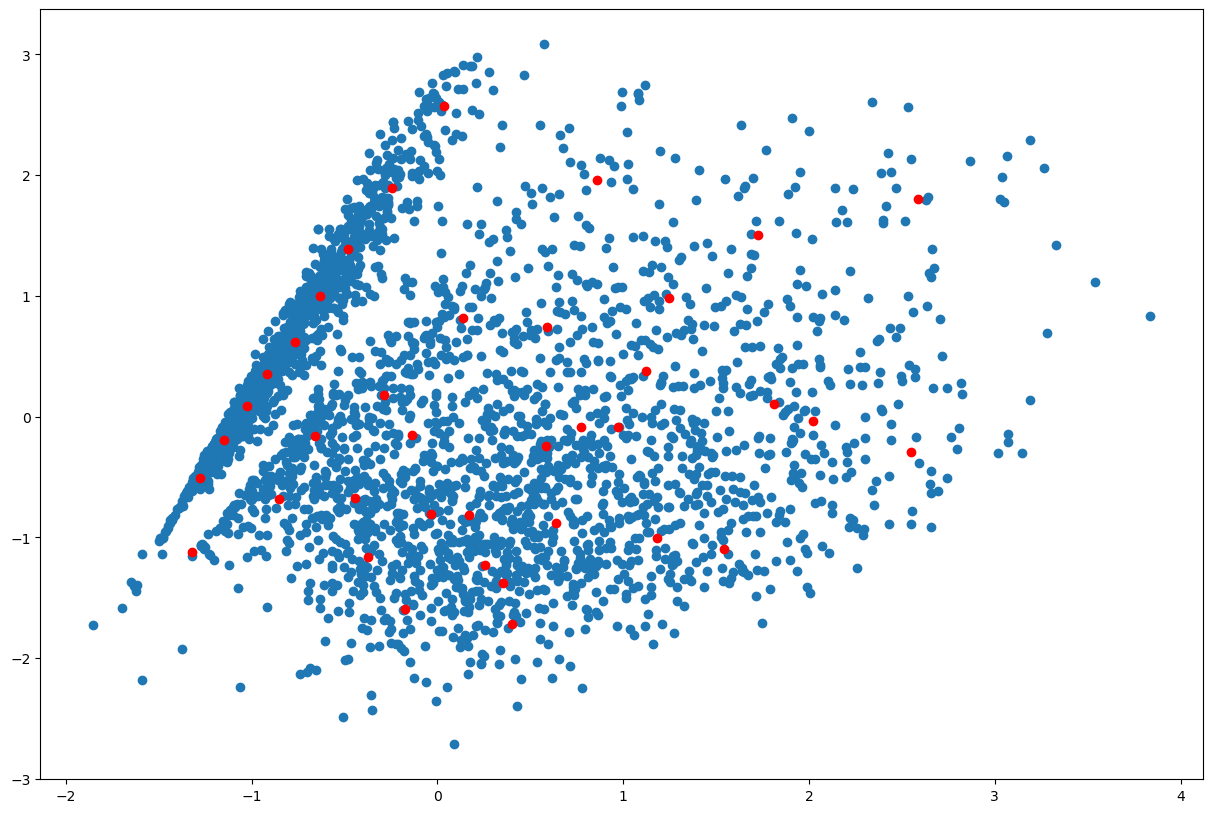

In [32]:
whitened = whiten(df_pca_working_set.values)

book = np.array((whitened[0],whitened[3000]))

codebook, distortion = kmeans(whitened, 38)

print("Centroids:\n", codebook)
print("Distortion:", distortion)

# Set the figure size
plt.figure(figsize=(15, 10))  # Width: 12 inches, Height: 8 inches
plt.scatter(whitened[:, 0], whitened[:, 1])

plt.scatter(codebook[:, 0], codebook[:, 1], c='r')

plt.show()